# 確率ロボティクス2017第13回

上田隆一

2017年12月6日@千葉工業大学

## 今日やること

* 多変量正規（ガウス）分布
* 拡張カルマンフィルタ

## 多変量正規（ガウス）分布

* こういう式
  * $p(\boldsymbol{x}) = \dfrac{1}{\sqrt{(2\pi)^n|\Sigma|}}e^{-\frac{1}{2}(\boldsymbol{x} - \boldsymbol{\mu})^T \Sigma^{-1} (\boldsymbol{x} - \boldsymbol{\mu})}$\par
    $= \dfrac{1}{\sqrt{(2\pi)^n|\Sigma|}}\exp\left\{-\dfrac{1}{2}(\boldsymbol{x} - \boldsymbol{\mu})^T \Sigma^{-1} (\boldsymbol{x} - \boldsymbol{\mu})\right\}$
    * $n$は$\boldsymbol{x}$の次元
* 以後単に「ガウス分布」と呼びます  
* 性質
  * $\boldsymbol{x}$の定義域で積分すると1（確率密度分布になっている）
    * $\boldsymbol{\mu}$が平均値
    * $\Sigma$が共分散行列（正確には分散共分散行列）
      * $\boldsymbol{x}$が2次元の場合: $\Sigma = \begin{pmatrix}\sigma_{xx},\sigma_{xy}\\\sigma_{xy}, \sigma_{yy}\end{pmatrix}$
        * $\sigma_{xx},\sigma_{yy}$: 分散
        * $\sigma_{xy}$: 共分散
  * ガウス分布同士の積もガウス分布
    * **確率の計算のときに平均と共分散だけ気にすればよい**
  * 多くの事象がガウス分布に従う
    * 雑音など
    
    
* $\mathcal{N}(\boldsymbol{\mu},\Sigma)$と略記

### ガウス分布のプログラミング

Pythonのライブラリを使って2次元のガウス分布の描画をしてみましょう。

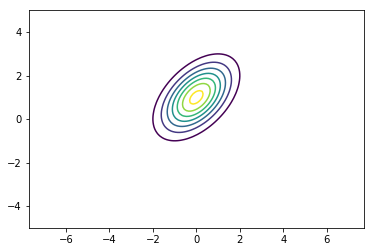

In [1]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

###平均と共分散行列###
mean = [0.0,1.0]
cov = [[1.0,0.5],
       [0.5,1.0]]

x_axis = np.linspace(-5, 5, 100)  #-5から5まで100刻みでリストを作る
y_axis = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x_axis,y_axis) #x_axisとy_axisから平面上の格子を作る

###bivariate_normal: 二次元のガウス分布の値を格子に対して求めるメソッド###
Z = mlab.bivariate_normal(X, Y, # 格子の座標
                          math.sqrt(cov[0][0]),math.sqrt(cov[1][1]),# x,yの標準偏差
                          mean[0], mean[1], # 平均
                          cov[0][1])            # 共分散

plt.contour(X, Y, Z)
plt.axis("equal")
plt.show()

### 自作のガウス分布クラス

In [2]:
from matplotlib.patches import Ellipse

class Gaussian2D:
    def __init__(self,mean,cov):
        self.mean = mean
        self.cov = cov
        
    # 値（密度）を返すメソッド
    def value(self,x,y):
        pos = np.array([[x],[y]])
        delta = pos - self.mean
        numerator = math.exp(-0.5 * (delta.T).dot(np.linalg.inv(self.cov)).dot(delta))
        denominator = 2 * math.pi * math.sqrt(np.linalg.det(self.cov))
        return numerator / denominator
    
    # ガウス分布を移動させるメソッド
    def shift(self,delta,angle):
        ###回転行列を作る###
        ca = math.cos(angle)
        sa = math.sin(angle)
        rot = np.array([[ca,-sa],[sa,ca]])
        
        self.cov = rot.dot(self.cov).dot(rot.T) #共分散行列を回転行列で挟む
        self.mean = self.mean + delta           #平均値はそのままシフト
        
    # 誤差楕円（ここでは単なる固有ベクトルに固有値をかけたものを長軸、短軸にした楕円）を返すメソッド
    def ellipse(self,color="blue"):
        eig_vals,eig_vec = np.linalg.eig(self.cov)

        v1 = eig_vals[0] * eig_vec[:,0]
        v2 = eig_vals[1] * eig_vec[:,1]
        v1_direction = math.atan2(v1[1],v1[0])
        
        e = Ellipse(self.mean,width=np.linalg.norm(v1),height=np.linalg.norm(v2),angle=v1_direction/math.pi*180)
        e.set_facecolor(color)
        e.set_alpha(0.2)
        
        return e

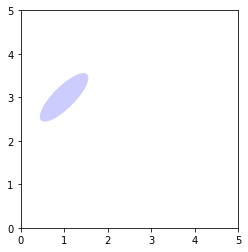

In [3]:
p = Gaussian2D(np.array([[1.0],[3.0]]),
               np.array([[1.0,0.5],
                         [0.5,1.0]]))

fig = plt.figure(0)
sp = fig.add_subplot(111, aspect='equal')

plt.xlim(0,5)
plt.ylim(0,5)
sp.add_artist(p.ellipse())
plt.show()

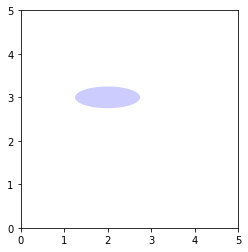

In [4]:
p.shift(np.array([[1.0],[0.0]]),-math.pi/4.0)
fig = plt.figure(0)
sp = fig.add_subplot(111, aspect='equal')

plt.xlim(0,5)
plt.ylim(0,5)
sp.add_artist(p.ellipse())
plt.show()

## ガウス分布同士の掛け算

* ガウス分布同士の掛け算は（正規化すると）ガウス分布になる
* ベイズの定理をガウス分布に適用すると出てくる（カルマンフィルタ）
* 多次元だととても計算が面倒

$\mathcal{N}(\boldsymbol{\mu},\Sigma) = \mathcal{N}(\boldsymbol{\mu}_1,\Sigma_1)\mathcal{N}(\boldsymbol{\mu}_2,\Sigma_2)$のとき
  * $\Sigma = (\Sigma_1^{-1} + \Sigma_2^{-1})^{-1}$
    * $\Sigma^{-1} = \Sigma_1^{-1} + \Sigma_2^{-1}$になっている
    * 共分散行列の逆行列は精度行列や情報行列と呼ばれ、込み入った計算でよく出てくる
  * $\boldsymbol{\mu} = (I-K)\boldsymbol{\mu}_1 + K\boldsymbol{\mu}_2 = (\Sigma_1^{-1} + \Sigma_2^{-1})^{-1}(\Sigma_1^{-1}\boldsymbol{\mu}_1 + \Sigma_2^{-1}\boldsymbol{\mu}_2)$
    * ここで $K = \Sigma \Sigma_2^{-1}$
    * よく見ると重み付き平均になっている

### 掛け算の関数

In [5]:
def multi(A,B):
    invA = np.linalg.inv(A.cov)
    invB = np.linalg.inv(B.cov)
    cov = np.linalg.inv(invA + invB)
    
    K = cov.dot(invB)
    mean = ( np.identity(2) - K ).dot(A.mean) + K.dot(B.mean)
    return Gaussian2D(mean,cov)

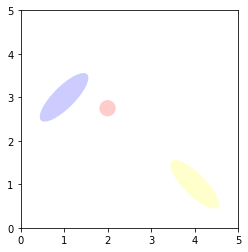

In [6]:
###使ってみましょう###

p = Gaussian2D(np.array([[1.0],[3.0]]),
               np.array([[1.0,0.5],
                         [0.5,1.0]]))

q = Gaussian2D(np.array([[4.0],[1.0]]),
               np.array([[1.0,-0.5],
                         [-0.5,1.0]]))

r = multi(p,q)

fig = plt.figure(0)
sp = fig.add_subplot(111, aspect='equal')

plt.xlim(0,5)
plt.ylim(0,5)
sp.add_artist(p.ellipse("blue"))
sp.add_artist(q.ellipse("yellow"))
sp.add_artist(r.ellipse("red"))
plt.show()

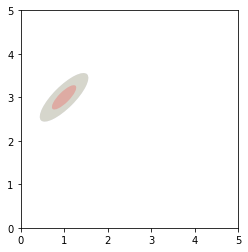

In [7]:
###使ってみましょう###

p = Gaussian2D(np.array([[1.0],[3.0]]),
               np.array([[1.0,0.5],
                         [0.5,1.0]]))

q = Gaussian2D(np.array([[1.0],[3.0]]),
               np.array([[1.0,0.5],
                         [0.5,1.0]])) 

r = multi(p,q)

fig = plt.figure(0)
sp = fig.add_subplot(111, aspect='equal')

plt.xlim(0,5)
plt.ylim(0,5)
sp.add_artist(p.ellipse("blue"))
sp.add_artist(q.ellipse("yellow"))
sp.add_artist(r.ellipse("red"))
plt.show()

### 既製のガウス分布

scipy.statsのmultivariate_normalを使うと楽。

https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html

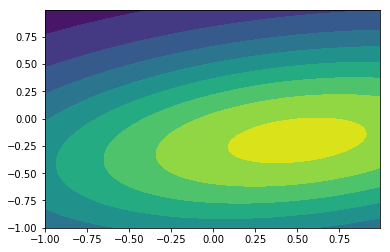

In [11]:
from scipy.stats import multivariate_normal

rv = multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])

x, y = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
plt.contourf(x, y, rv.pdf(pos))

### ということで
* もう一度FastSLAMのコードを読んでみましょう